In [95]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from tqdm import tqdm

# Read the initial data
data_path = 'data/mann_bruker_simplified.txt'
df = pd.read_csv(data_path, sep=',')

# Print the initial row count
initial_rows = len(df)
print(f"Initial rows: {initial_rows}")

# Step 1: Filter to only include unmodified sequences
df = df[df['Modifications'] == 'Unmodified']
remaining_rows = len(df)
eliminated = initial_rows - remaining_rows
print(f"Remaining rows after filtering 'Unmodified' sequences: {remaining_rows} (Eliminated: {eliminated})")

# Step 2: Drop rows with empty CCS or Sequence values
before_dropna = len(df)
df = df.dropna(subset=['CCS', 'Sequence'])
remaining_rows = len(df)
eliminated = before_dropna - remaining_rows
print(f"Remaining rows after dropping NaN in 'CCS' or 'Sequence': {remaining_rows} (Eliminated: {eliminated})")

# Step 3: Read the mass data
mass_data_path = 'data/mann_bruker.txt'
mass_df = pd.read_csv(mass_data_path, sep='\t')

# Step 4: Ensure `mass_df` contains unique combinations of Sequence and Charge
before_dedup = len(mass_df)
mass_df = mass_df.drop_duplicates(subset=['Sequence', 'Charge'])
remaining_rows = len(mass_df)
eliminated = before_dedup - remaining_rows
print(f"Remaining rows in mass data after removing duplicates: {remaining_rows} (Eliminated: {eliminated})")

# Step 5: Merge the mass data with the sequence data on Sequence and Charge
before_merge = len(df)
df = pd.merge(df, mass_df[['Sequence', 'Charge', 'Mass']], on=['Sequence', 'Charge'], how='left')
remaining_rows = len(df)
eliminated = before_merge - remaining_rows
print(f"Remaining rows after merging with mass data: {remaining_rows} (Eliminated: {eliminated})")

# Step 6: Drop rows where the mass data is missing (NaN)
before_dropna_mass = len(df)
df = df.dropna(subset=['Mass'])
remaining_rows = len(df)
eliminated = before_dropna_mass - remaining_rows
print(f"Remaining rows after dropping rows with NaN 'Mass': {remaining_rows} (Eliminated: {eliminated})")

# Step 7: Remove duplicates and calculate mean CCS for each unique sequence and charge
before_grouping = len(df)
df_grouped = df.groupby(['Sequence', 'Charge'], as_index=False).agg({
    'CCS': 'mean',
    'Mass': 'first'  # Keep the mass as is, since it doesn't need aggregation
})

remaining_rows = len(df_grouped)
eliminated = before_grouping - remaining_rows
print(f"Remaining rows after removing duplicates (grouping by 'Sequence' and 'Charge'): {remaining_rows} (Eliminated: {eliminated})")

# Add a column for sequence length
df_grouped['Length'] = df_grouped['Sequence'].apply(len)

# Step 7b: Compare mean vs. median CCS values
df_grouped_median = df.groupby(['Sequence', 'Charge'], as_index=False).agg({
    'CCS': 'median',
    'Mass': 'first'
})

# Merge mean and median CCS values
df_comparison = pd.merge(df_grouped, df_grouped_median[['Sequence', 'Charge', 'CCS']], 
                         on=['Sequence', 'Charge'], suffixes=('_mean', '_median'))

# Calculate absolute and percentage differences
df_comparison['CCS_diff'] = abs(df_comparison['CCS_mean'] - df_comparison['CCS_median'])
df_comparison['CCS_diff_percent'] = (df_comparison['CCS_diff'] / df_comparison['CCS_mean']) * 100

# Count how many times the difference exceeds 5%
num_differences = (df_comparison['CCS_diff_percent'] > 5).sum()
total_sequences = len(df_comparison)
percentage_different = (num_differences / total_sequences) * 100

print(f"Number of cases where mean vs. median CCS differs by more than 5%: {num_differences}")
print(f"Percentage of total cases affected: {percentage_different:.2f}%")

# Save the comparison dataset
comparison_output_path = 'data/ccs_mean_vs_median_comparison.csv'
df_comparison.to_csv(comparison_output_path, index=False)


# Step 8: Calculate RDKit descriptors
def calculate_descriptors(sequence):
    mol = Chem.MolFromFASTA(sequence)
    if mol is None:
        return pd.Series([None, None, None])
    num_atoms = Descriptors.HeavyAtomCount(mol)
    num_rotatable_bonds = Descriptors.NumRotatableBonds(mol)
    fraction_sp3 = Descriptors.FractionCSP3(mol)
    return pd.Series([num_atoms, num_rotatable_bonds, fraction_sp3])

# Apply the descriptor calculation with a progress bar
tqdm.pandas()
df_grouped[['NumAtoms', 'NumRotatableBonds', 'FractionSP3']] = df_grouped['Sequence'].progress_apply(calculate_descriptors)

# Step 9: Check if the mean CCS is more than 1% away from the original values

# Merge back the original CCS values for comparison
df_merged = pd.merge(df, df_grouped[['Sequence', 'Charge', 'CCS']], on=['Sequence', 'Charge'], suffixes=('_original', '_mean'))

# Calculate absolute difference and check if it's more than 1% away
df_merged['CCS_diff'] = abs(df_merged['CCS_original'] - df_merged['CCS_mean'])
df_merged['CCS_threshold'] = df_merged['CCS_original'] * 0.1

# Filter cases where the difference exceeds 1%
df_outliers = df_merged[df_merged['CCS_diff'] > df_merged['CCS_threshold']]

# Print affected sequences
if not df_outliers.empty:
    print("\nSequences where mean CCS deviates by more than 1%:")
    for _, row in df_outliers.iterrows():
        print(f"Sequence: {row['Sequence']}, Charge: {row['Charge']}, "
              f"Original CCS: {row['CCS_original']}, Mean CCS: {row['CCS_mean']}")
        

# Final rows count
print(f"Final rows after descriptor calculation: {len(df_grouped)}")

# Save the final dataset
output_path = 'data/final_data_simplified.csv'
df_grouped.to_csv(output_path, index=False)


Initial rows: 321607
Remaining rows after filtering 'Unmodified' sequences: 302323 (Eliminated: 19284)
Remaining rows after dropping NaN in 'CCS' or 'Sequence': 302323 (Eliminated: 0)
Remaining rows in mass data after removing duplicates: 231611 (Eliminated: 209151)
Remaining rows after merging with mass data: 302323 (Eliminated: 0)
Remaining rows after dropping rows with NaN 'Mass': 302323 (Eliminated: 0)
Remaining rows after removing duplicates (grouping by 'Sequence' and 'Charge'): 144117 (Eliminated: 158206)
Number of cases where mean vs. median CCS differs by more than 5%: 182
Percentage of total cases affected: 0.13%


100%|██████████| 144117/144117 [00:39<00:00, 3677.53it/s]



Sequences where mean CCS deviates by more than 1%:
Sequence: AAESLTAIPEPASPQLLETPIHASQIQK, Charge: 3, Original CCS: 2.40232112312869e-35, Mean CCS: 2.13619338216697e-35
Sequence: AAESLTAIPEPASPQLLETPIHASQIQK, Charge: 3, Original CCS: 2.3950960686963802e-35, Mean CCS: 2.13619338216697e-35
Sequence: AAGDHAK, Charge: 1, Original CCS: 8.944694936232979e-36, Mean CCS: 7.366223895360484e-36
Sequence: AAGGGAK, Charge: 1, Original CCS: 1.1765977272384601e-35, Mean CCS: 7.932573407548445e-36
Sequence: AAGGGAK, Charge: 1, Original CCS: 1.1765995916351801e-35, Mean CCS: 7.932573407548445e-36
Sequence: AAGGGSR, Charge: 1, Original CCS: 9.57815493565312e-36, Mean CCS: 7.709879249255489e-36
Sequence: AAGGKMK, Charge: 1, Original CCS: 9.65149953542898e-36, Mean CCS: 8.210427797961205e-36
Sequence: AAGGKMK, Charge: 1, Original CCS: 6.769356060493429e-36, Mean CCS: 8.210427797961205e-36
Sequence: AAHEFTT, Charge: 1, Original CCS: 8.136937691784359e-36, Mean CCS: 7.027984440491896e-36
Sequence: AALRPTD

In [96]:
import pandas as pd

# Read the initial data
data_path = 'data/mann_bruker_simplified.txt'
df = pd.read_csv(data_path, sep=',')

# Number of data points in the original data
original_data_points = len(df)

# Read the final processed data
output_path = 'data/final_data_simplified.csv'
df_grouped = pd.read_csv(output_path)

# Number of data points in the final processed data
final_data_points = len(df_grouped)

print(f"Number of data points in the original data: {original_data_points}")
print(f"Number of data points in the final processed data: {final_data_points}")


print(max(df_grouped['Length']))
print(min(df_grouped['Length']))

Number of data points in the original data: 321607
Number of data points in the final processed data: 144117
52
7


In [97]:
import pandas as pd

# Read the final processed data
output_path = 'data/final_data_simplified.csv'
df_grouped = pd.read_csv(output_path)

# Check for empty values and print the Sequence and column name
empty_values = df_grouped.isnull()
for index, row in empty_values.iterrows():
    if row.any():
        sequence = df_grouped.loc[index, 'Sequence']
        empty_columns = row[row].index.tolist()
        for column in empty_columns:
            print(f"Sequence: {sequence}, Empty Value in Column: {column}")


# Check if all sequence and charge combinations are unique
duplicates = df_grouped.duplicated(subset=['Sequence', 'Charge'])
all_unique = not duplicates.any()

print(f"All sequence and charge combinations are unique: {all_unique}")

# Print some examples with all columns
print("Examples of data:")
print(df_grouped.head())

# If there are duplicates, print some examples with all columns
if not all_unique:
    print("Examples of duplicate sequence and charge combinations:")
    print(df_grouped[duplicates].head())
    
# print the number of different sequences
# Read the final processed data
output_path = 'data/final_data_simplified.csv'
df_grouped = pd.read_csv(output_path)

# Print the number of different sequences
num_unique_sequences = df_grouped['Sequence'].nunique()
print(f"Number of different sequences: {num_unique_sequences}")

# Group by Sequence and count unique charges
sequence_charge_counts = df_grouped.groupby('Sequence')['Charge'].nunique()

# Filter sequences with more than one unique charge
sequences_with_multiple_charges = sequence_charge_counts[sequence_charge_counts > 1]

# Print the number of sequences with different charges
num_sequences_with_multiple_charges = len(sequences_with_multiple_charges)
print(f"Number of sequences with different charges: {num_sequences_with_multiple_charges}")





Sequence: NQAKKUEUPSN, Empty Value in Column: NumAtoms
Sequence: NQAKKUEUPSN, Empty Value in Column: NumRotatableBonds
Sequence: NQAKKUEUPSN, Empty Value in Column: FractionSP3
Sequence: QLSSHFQIYPFSLRKPNSDULGMEEK, Empty Value in Column: NumAtoms
Sequence: QLSSHFQIYPFSLRKPNSDULGMEEK, Empty Value in Column: NumRotatableBonds
Sequence: QLSSHFQIYPFSLRKPNSDULGMEEK, Empty Value in Column: FractionSP3
Sequence: VLIRVTYCGLUSYSLRYILLK, Empty Value in Column: NumAtoms
Sequence: VLIRVTYCGLUSYSLRYILLK, Empty Value in Column: NumRotatableBonds
Sequence: VLIRVTYCGLUSYSLRYILLK, Empty Value in Column: FractionSP3
Sequence: VLLIENVASLUGTTVR, Empty Value in Column: NumAtoms
Sequence: VLLIENVASLUGTTVR, Empty Value in Column: NumRotatableBonds
Sequence: VLLIENVASLUGTTVR, Empty Value in Column: FractionSP3
All sequence and charge combinations are unique: True
Examples of data:
                                            Sequence  Charge           CCS  \
0  AAAAAAAAAAAATGTEAGPGTAGGSENGSEVAAQPAGLSGPAEVGP...

In [98]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

def getSplittedData(selected_features, train_size, val_size, test_size):
    # load data
    file_path = 'data/final_data_simplified.csv'
    data = pd.read_csv(file_path, sep=",").dropna()

    # Nach Sequenzen gruppieren
    grouped = data.groupby("Sequence")
    # Erstellen einer Liste, in der jede Sequenz eine Gruppe ist
    grouped_data = [(seq, group) for seq, group in grouped]

    # Splitten (z.B. 75% Training, 10% Validation, 15% Test)
    train_cur, test_groups = train_test_split(grouped_data, test_size=test_size, random_state=42)

    # Zweiter Split: Trainingsdaten in Training und Validierung aufteilen (z.B. 8/9) für Training und 1/9 für Validierung)
    train_groups, val_groups = train_test_split(train_cur, test_size=val_size/(1-test_size), random_state=42)  #1/9 * 0.9 = 0.1 für val

    # Schritt 3: Die Gruppendaten wieder in DataFrames konvertieren
    train_df = pd.concat([group for _, group in train_groups])
    test_df = pd.concat([group for _, group in test_groups])
    val_df = pd.concat([group for _, group in val_groups])

    y_scaler = MinMaxScaler()
    X_scaler = MinMaxScaler()

    # scale train
    y_train_unscaled = train_df['CCS'].values.reshape(-1, 1) * 1e40
    y_train = y_scaler.fit_transform(y_train_unscaled)
    X_train_unscaled = train_df[selected_features]
    X_train = pd.DataFrame(X_scaler.fit_transform(X_train_unscaled), columns=X_train_unscaled.columns)

    # scale validation
    y_val_unscaled = val_df['CCS'].values.reshape(-1, 1) * 1e40
    y_val = y_scaler.transform(y_val_unscaled)
    X_val_unscaled = val_df[selected_features]
    X_val = pd.DataFrame(X_scaler.transform(X_val_unscaled), columns=X_val_unscaled.columns)

    # scale test
    y_test_unscaled = test_df['CCS'].values.reshape(-1, 1) * 1e40
    y_test = y_scaler.transform(y_test_unscaled)
    X_test_unscaled = test_df[selected_features]
    X_test = pd.DataFrame(X_scaler.transform(X_test_unscaled), columns=X_test_unscaled.columns)




    return y_train, y_val, y_test, X_train, X_val, X_test


# Define the selected features and sizes
selected_features = ['Charge', 'Mass', 'Length', 'NumAtoms', 'NumRotatableBonds', 'FractionSP3']
train_size = 0.75
val_size = 0.10
test_size = 0.15

# Call the function to get the data splits
y_train, y_val, y_test, X_train, X_val, X_test = getSplittedData(selected_features, train_size, val_size, test_size)

# Create data folder if it doesn't exist
os.makedirs('data/simplified', exist_ok=True)

# Save the data to CSV files
X_train.to_csv('data/simplified/X_train.csv', index=False)
X_val.to_csv('data/simplified/X_val.csv', index=False)
X_test.to_csv('data/simplified/X_test.csv', index=False)
pd.DataFrame(y_train, columns=['CCS']).to_csv('data/simplified/y_train.csv', index=False)
pd.DataFrame(y_val, columns=['CCS']).to_csv('data/simplified/y_val.csv', index=False)
pd.DataFrame(y_test, columns=['CCS']).to_csv('data/simplified/y_test.csv', index=False)



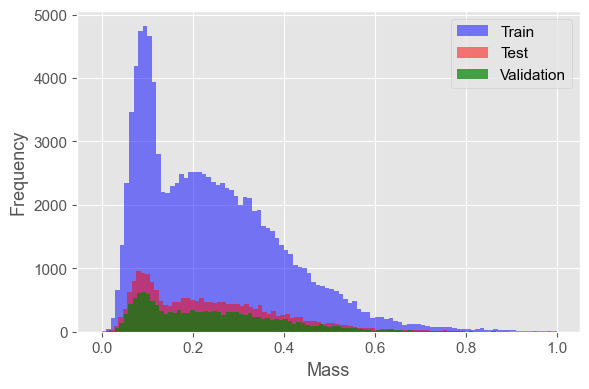

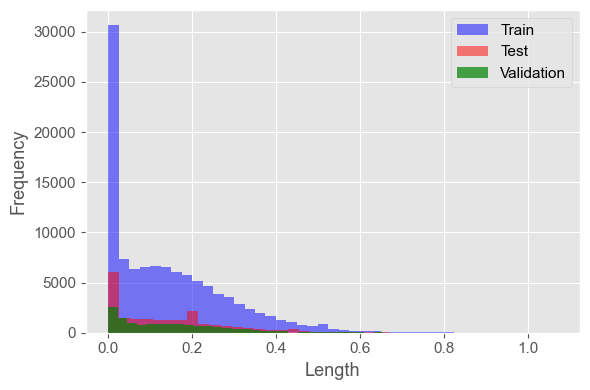

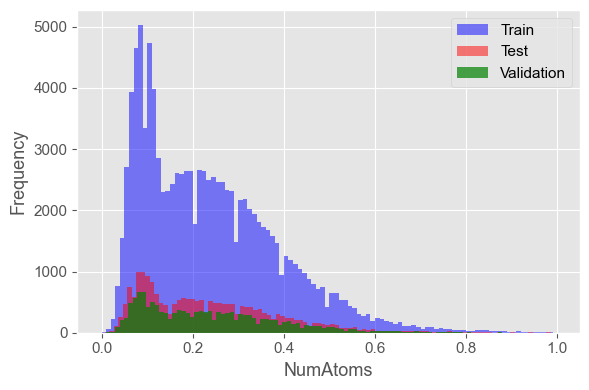

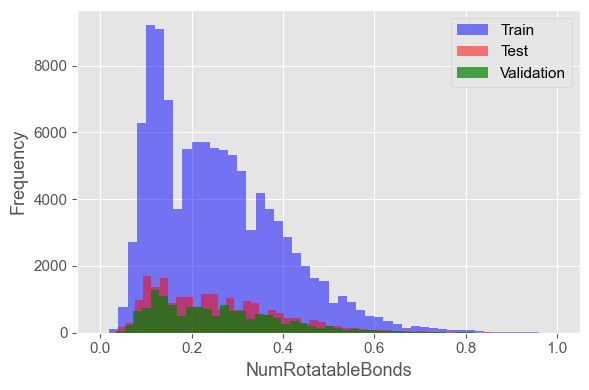

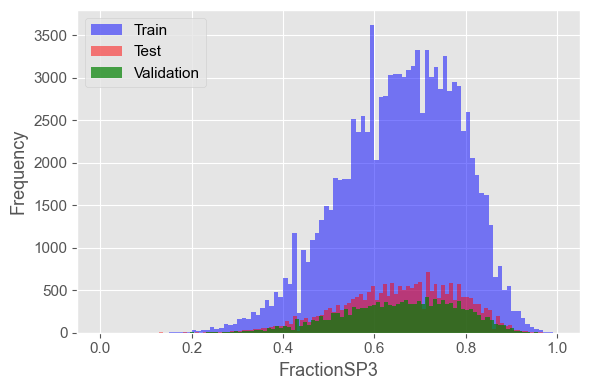

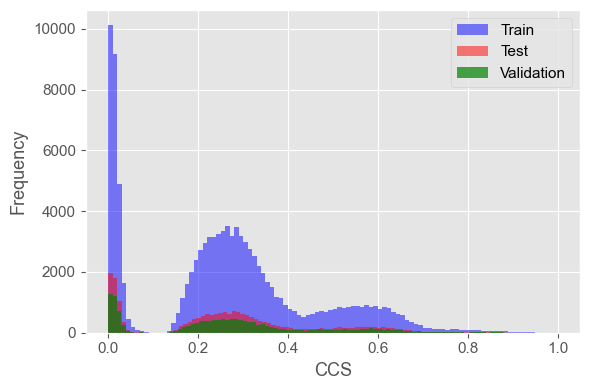

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Define the folder path
folder_path = 'pictures/simplified'

# Check if the folder exists, if not, create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Load the train, validation, and test datasets
X_train = pd.read_csv('data/simplified/X_train.csv')
X_val = pd.read_csv('data/simplified/X_val.csv')
X_test = pd.read_csv('data/simplified/X_test.csv')
y_train = pd.read_csv('data/simplified/y_train.csv')
y_val = pd.read_csv('data/simplified/y_val.csv')
y_test = pd.read_csv('data/simplified/y_test.csv')

# Define the features to plot
features = ['Mass', 'Length', 'NumAtoms', 'NumRotatableBonds', 'FractionSP3']

# Set ggplot style
plt.style.use('ggplot')
# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'

# Plot the distribution of each feature for each dataset
for feature in features:
    plt.figure(figsize=(6, 4))
    if(feature=='Length'):
        # Plot train set
        plt.hist(X_train[feature], bins=40, alpha=0.5, label='Train', color='blue', zorder=1)
        # Plot test set
        plt.hist(X_test[feature], bins=40, alpha=0.5, label='Test', color='red', zorder=2)
        # Plot validation set
        plt.hist(X_val[feature], bins=40, alpha=0.7, label='Validation', color='green', zorder=3)
    elif(feature=='NumRotatableBonds'):
        # Plot train set
        plt.hist(X_train[feature], bins=50, alpha=0.5, label='Train', color='blue', zorder=1)
        # Plot test set
        plt.hist(X_test[feature], bins=50, alpha=0.5, label='Test', color='red', zorder=2)
        # Plot validation set
        plt.hist(X_val[feature], bins=50, alpha=0.7, label='Validation', color='green', zorder=3)
    else:
        # Plot train set
        plt.hist(X_train[feature], bins=100, alpha=0.5, label='Train', color='blue', zorder=1)
    
        # Plot test set
        plt.hist(X_test[feature], bins=100, alpha=0.5, label='Test', color='red', zorder=2)
    
        # Plot validation set
        plt.hist(X_val[feature], bins=100, alpha=0.7, label='Validation', color='green', zorder=3)
    
    plt.xlabel(feature, fontsize=13)
    plt.ylabel('Frequency', fontsize=13)
    plt.legend(fontsize=11)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    # plt.title(f'Distribution of {feature}', fontsize=18)
    plt.tight_layout()
    plt.savefig(f'pictures/simplified/{feature}_distribution_simplified.png', dpi=300)
    plt.show()

# Plot the distribution of CCS for each dataset
plt.figure(figsize=(6, 4))

# Plot train set
plt.hist(y_train['CCS'], bins=100, alpha=0.5, label='Train', color='blue', zorder=1)

# Plot test set
plt.hist(y_test['CCS'], bins=100, alpha=0.5, label='Test', color='red', zorder=2)

# Plot validation set
plt.hist(y_val['CCS'], bins=100, alpha=0.7, label='Validation', color='green', zorder=3)

plt.xlabel('CCS', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.legend(fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# plt.title('Distribution of CCS', fontsize=18)
plt.tight_layout()
plt.savefig('pictures/simplified/CCS_distribution_simplified.png', dpi=300)
plt.show()

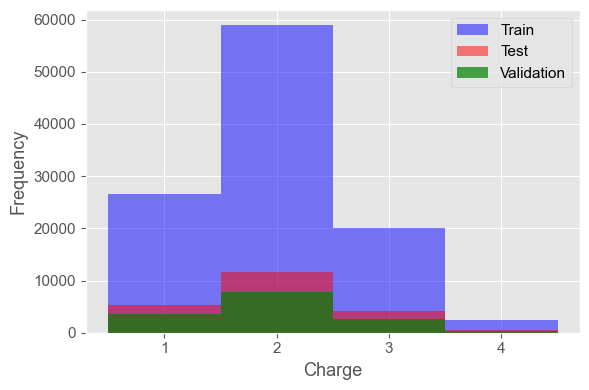

In [100]:
def map_to_charge_category(normalized_value):
    if normalized_value == 0:
        return 1
    elif 0 < normalized_value <= 0.34:
        return 2
    elif 0.34 < normalized_value <= 0.67:
        return 3
    elif 0.67 < normalized_value <= 1:
        return 4
    else:
        return 1  # Default 

# Apply the mapping function to each dataset
X_train['ChargeCategory'] = X_train['Charge'].apply(map_to_charge_category)
X_test['ChargeCategory'] = X_test['Charge'].apply(map_to_charge_category)
X_val['ChargeCategory'] = X_val['Charge'].apply(map_to_charge_category)

# Plot the distribution of ChargeCategory for each dataset
# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(6, 4))

# Plot train set
plt.hist(X_train['ChargeCategory'], bins=[1, 2, 3, 4, 5], alpha=0.5, label='Train', color='blue', zorder=1, align='left')

# Plot test set
plt.hist(X_test['ChargeCategory'], bins=[1, 2, 3, 4, 5], alpha=0.5, label='Test', color='red', zorder=2, align='left')

# Plot validation set
plt.hist(X_val['ChargeCategory'], bins=[1, 2, 3, 4, 5], alpha=0.7, label='Validation', color='green', zorder=3, align='left')

plt.xlabel('Charge', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.legend(fontsize=11)
plt.xticks([1, 2, 3, 4], fontsize=11)
plt.yticks(fontsize=11)
# plt.title('Distribution of Charge Categories', fontsize=18)
plt.tight_layout()
plt.savefig('pictures/simplified/ChargeCategory_distribution_simplified.png', dpi=300)
plt.show()



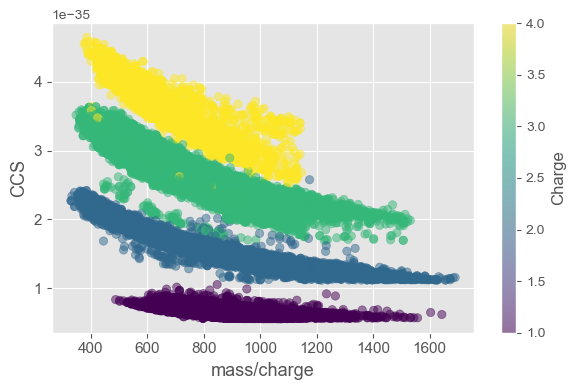

In [101]:
import pandas as pd
import matplotlib.pyplot as plt

import os

# Define the folder path
folder_path = 'pictures'
# Check if the folder exists, if not, create it
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Read the final processed data
file_path = 'data/final_data_simplified.csv'
df_grouped = pd.read_csv(file_path)

# Calculate mass/Charge ratio
df_grouped['mass/Charge'] = df_grouped['Mass'] / df_grouped['Charge']

# Plot distribution of CCS vs mass/Charge with color based on Charge
# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'
plt.figure(figsize=(6, 4))
scatter = plt.scatter(df_grouped['mass/Charge'], df_grouped['CCS'], c=df_grouped['Charge'], cmap='viridis', alpha=0.5)
plt.ylabel('CCS', fontsize=13)
plt.xlabel('mass/charge', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.colorbar(scatter, label='Charge')
plt.tight_layout()
plt.savefig('pictures/simplified/CCS_vs_mass_Charge_colored_by_Charge_simplified.png', dpi=300)
plt.show()

In [102]:
# Test the function with the sequence 'HCHCCUR' since it does not give values 
sequence = 'HCHCCUR'
descriptors = calculate_descriptors(sequence)
print(f"Descriptors for sequence {sequence}: {descriptors.tolist()}")

Descriptors for sequence HCHCCUR: [None, None, None]


In [103]:
import rdkit
print(rdkit.__version__)


2024.03.1


In [105]:
path = 'data/ccs_mean_vs_median_comparison.csv'

# print how often the mean and median differ by more than 5%
df = pd.read_csv(path)
num_differences = (df['CCS_diff_percent'] > 5).sum()
total_sequences = len(df)
percentage_different = (num_differences / total_sequences) * 100

print(f"Number of cases where mean vs. median CCS differs by more than 5%: {num_differences}")



Number of cases where mean vs. median CCS differs by more than 5%: 182
